In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.nn.functional as F

import numpy as np


import matplotlib.pyplot as plt

from PIL import Image

import os
import glob

In [43]:
class CustomDataLoader(Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform

        shuffled_indices = np.random.permutation(len(labels))

        self.images = [images[index] for index in shuffled_indices]
        self.labels = [labels[index] for index in shuffled_indices]


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [44]:
def load_and_resize_image(image_path):
    image = Image.open(image_path)  

    # Constantes / Constants
    IMG_SIZE = 144
    preprocess = transforms.Compose([
                    transforms.Resize((IMG_SIZE, IMG_SIZE)),
                    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values (mean and std values are common for many pre-trained models)
                    ])
    
    # return preprocess(resized_image)
    return preprocess(image)

def add_image_to_lists(jpeg_file_list, image_list, label_list, label):
    for jpeg_file in jpeg_file_list:
        tensor_image = load_and_resize_image(jpeg_file)
        image_list.append(tensor_image)
        label_list.append(label)

In [45]:
root_directory = "dataset_chat/" 
subdirectories = [d for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]

train_images = []
val_images = []
test_images = []
train_labels = []
val_labels = []
test_labels = []

# n_classes = 10
n_classes = 100
img_debut = 2

# img_per_class = 10
required_train_imgs = 9
required_val_imgs = 1
required_test_imgs = 1
required_images_per_cat = required_train_imgs + required_val_imgs + required_test_imgs

current_index = 0
max_index = len(subdirectories)
current_amount_of_classes = 0
while current_amount_of_classes < n_classes and current_index < max_index:
    subdirectory = subdirectories[current_index]
    subdirectory_path = os.path.join(root_directory, subdirectory)
    jpeg_files = glob.glob(os.path.join(subdirectory_path, "*.jpg"))
        
    if len(jpeg_files) < required_images_per_cat:
        print(f"{subdirectory_path} does not contain enough images, will not be used")
    else:
        print('Chargement de ' + subdirectory_path + '  ->  ' + str(required_images_per_cat) + '/' + str(len(jpeg_files)) + ' images')
        
        label = torch.zeros(n_classes)
        label[current_amount_of_classes] = 1  
        add_image_to_lists(jpeg_files[:required_train_imgs], train_images, train_labels, label)
        add_image_to_lists(jpeg_files[required_train_imgs:required_train_imgs+required_val_imgs], val_images, val_labels, label)
        add_image_to_lists(jpeg_files[required_train_imgs+required_val_imgs:], test_images, test_labels, label)

        
        current_amount_of_classes += 1
        
    current_index += 1
           
        

if current_amount_of_classes < n_classes:
    print(f"Could not find {n_classes} valid classes in dataset, only {current_amount_of_classes} classes will be used")
    n_classes = current_amount_of_classes

print('Done!')

Chargement de dataset_chat/0001  ->  11/17 images
Chargement de dataset_chat/0002  ->  11/20 images
Chargement de dataset_chat/0003  ->  11/15 images
Chargement de dataset_chat/0004  ->  11/56 images
Chargement de dataset_chat/0005  ->  11/41 images
Chargement de dataset_chat/0006  ->  11/40 images
Chargement de dataset_chat/0007  ->  11/41 images
Chargement de dataset_chat/0008  ->  11/18 images
Chargement de dataset_chat/0009  ->  11/13 images
Chargement de dataset_chat/0010  ->  11/36 images
Chargement de dataset_chat/0011  ->  11/26 images
Chargement de dataset_chat/0012  ->  11/17 images
dataset_chat/0013 does not contain enough images, will not be used
Chargement de dataset_chat/0014  ->  11/16 images
Chargement de dataset_chat/0015  ->  11/53 images
Chargement de dataset_chat/0016  ->  11/32 images
Chargement de dataset_chat/0017  ->  11/62 images
Chargement de dataset_chat/0018  ->  11/54 images
Chargement de dataset_chat/0019  ->  11/46 images
Chargement de dataset_chat/0020  

In [46]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, pretrained = True):
        super().__init__()
        self.model = models.resnet18(pretrained = pretrained, progress=False)     

        if pretrained:
            # on gèle les paramètres
            for param in self.model.parameters():
                param.requires_grad = False
        
        dim_before_fc = self.model.fc.in_features

        # de base, requires_grad = True
        self.model.fc = nn.Linear(dim_before_fc, num_classes) 
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.model.forward(x)
        return self.sigmoid(x)
        # return x


In [47]:
def eval_model(model, eval_dataset, epoch, num_epochs):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in eval_dataset:
            images = images.unsqueeze(0)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            for i in range(len(labels)):
                if predicted == np.argmax(labels):
                    correct += 1

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

    model.train()

    return accuracy

In [48]:
# params du modèle, essayer avec gridsearch (idéalement Randomized pour ne pas prendre énormément de temps), avec une bonne machine durant la nuit ou qqch
# faudrait idéalement logger les performances selon chaque combination de params pour s'amuser
num_epochs = 4
batch_size = 8
learning_rate = 1e-3
momentum = 0.5
weight_decay = 1e-5 


model = SimpleCNN(n_classes)
model.train()
train_dataset = CustomDataLoader(train_images, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

val_dataset = CustomDataLoader(val_images, val_labels)




criterion = nn.CrossEntropyLoss()
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(params, lr = learning_rate)

# Gossage sur les params potentiel
# criterion = nn.CrossEntropyLoss(reduction = 'sum')
# criterion = nn.CrossEntropyLoss(reduction = 'none')
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(params, lr = learning_rate, weight_decay = weight_decay)
# optimizer = optim.SGD(params, lr = learning_rate, momentum = momentum)   


accuracy_at_each_epoch = []
for epoch in range(num_epochs):
    print(epoch)
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    accuracy_at_each_epoch.append(eval_model(model, val_dataset, epoch, num_epochs))
    
print('Training and evaluation finished.')

for epoch, accuracy in enumerate(accuracy_at_each_epoch):
    print('Epoch ' + str(epoch) + ' : ' + str(accuracy) + '%')


c:\Users\Antoine\miniconda3\envs\CatProject\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Antoine\miniconda3\envs\CatProject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0
Epoch [1/4], Test Accuracy: 42.00%
1
Epoch [2/4], Test Accuracy: 63.00%
2
Epoch [3/4], Test Accuracy: 68.00%
3
Epoch [4/4], Test Accuracy: 73.00%
Training and evaluation finished.
Epoch 0 : 42.0%
Epoch 1 : 63.0%
Epoch 2 : 68.0%
Epoch 3 : 73.0%


Text(0, 0.5, 'Accuracy (%)')

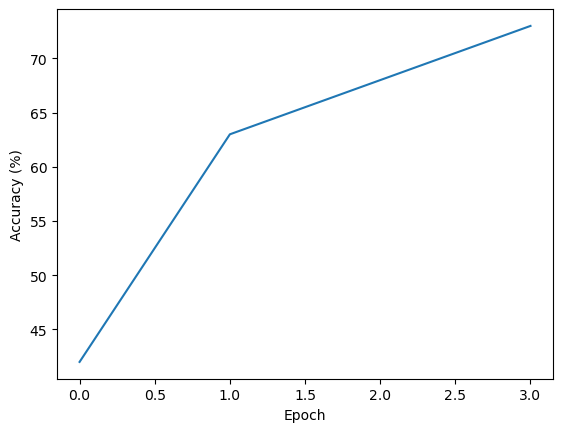

In [49]:
plt.plot(accuracy_at_each_epoch)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

In [50]:
print(len(test_images))

test_dataset = CustomDataLoader(test_images, test_labels)
eval_model(model, test_dataset, 1, 1)

1902


KeyboardInterrupt: 